# Understanding YOLO Output

## Yolo output have 3 scale and each scale have 3 anchor
(x,y, (anchor*5+class) )
(x,y,anchor,5+class) 5 - > consist of (x,y,w,h,conf)

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import numpy as np
import keras.backend as K
import h5py
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Lambda ,Reshape
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

from model.core import yolo_head,preprocess_true_boxes, yolo_loss
from model.yolo3 import yolo_body, tiny_yolo_body
from model.utils import get_random_data

from tqdm import tqdm
import time

Using TensorFlow backend.


In [2]:

def get_classes(classes_path):
    '''loads the classes'''
    with open(classes_path) as f:
        class_names = f.readlines()
    class_names = [c.strip() for c in class_names]
    return class_names

def get_anchors(anchors_path):
    '''loads the anchors from a file'''
    with open(anchors_path) as f:
        anchors = f.readline()
    anchors = [float(x) for x in anchors.split(',')]
    return np.array(anchors).reshape(-1, 2)

In [3]:
def data_generator(annotation_lines, batch_size, input_shape, anchors, num_classes,model):
    '''data generator for fit_generator'''

    n = len(annotation_lines)
    i = 0
    while True:
        image_data = []
        box_data = []
        for b in range(batch_size):
            if i==0:
                np.random.shuffle(annotation_lines)
            image, box = get_random_data(annotation_lines[i], input_shape, random=True)
            image_data.append(image)
            box_data.append(box)
            i = (i+1) % n
        image_data = np.array(image_data)
        box_data = np.array(box_data)
        y_true = preprocess_true_boxes(box_data, input_shape, anchors, num_classes)
       # print(image_data.shape)
        m_true = model.predict(image_data)
     

        yield image_data , box_data , y_true , m_true  #, np.zeros(batch_size)

def data_generator_wrapper(annotation_lines, batch_size, input_shape, anchors, num_classes,model):
    n = len(annotation_lines)
    if n==0 or batch_size<=0: return None
    return data_generator(annotation_lines, batch_size, input_shape, anchors, num_classes,model)

In [4]:
train_path = '2007_train.txt'
val_path = '2007_val.txt'
# test_path = '2007_test.txt'
log_dir = 'logs/000/'
classes_path = 'class/voc_classes.txt'
anchors_path = 'anchors/yolo_anchors.txt'
class_names = get_classes(classes_path)
num_classes = len(class_names)
anchors = get_anchors(anchors_path)
num_anchors = len(anchors)

input_shape = (416,416) # multiple of 32, hw

with open(train_path) as f:
    train_lines = f.readlines()

with open(val_path) as f:
    val_lines = f.readlines()

# with open(test_path) as f:
#     test_lines = f.readlines()

num_anchors = len(anchors)
image_input = Input(shape=(416, 416, 3))
model = yolo_body(image_input, num_anchors//3, num_classes)
model.load_weights("model_data/trained_weights_final.h5")

yolo3 = Reshape((13, 13, 3, 25))(model.layers[-3].output)
yolo2 = Reshape((26, 26, 3, 25))(model.layers[-2].output)
yolo1 = Reshape((52, 52, 3, 25))(model.layers[-1].output)


model = Model( inputs= model.input , outputs=[yolo3,yolo2,yolo1] )

batch_size = 1

In [65]:

        # create an hdf5 file
train_size = 5 #len(train_lines)
image = {}
box = {}
train_logits = {}
model_logits = {}

print( "total "+ str(len(train_lines)) + " loop "+ str( train_size ) )

i = 0 #step
for  img,box_data,flogits,mlogits in data_generator_wrapper(train_lines, batch_size, input_shape, anchors, num_classes,model) : 
    #x , y = dat
    image[i] = img
    box[i] = box_data
    train_logits[i] = flogits
    model_logits[i] = mlogits

    i+=1
    if i>= train_size:#(len(train_lines)) :
        break

total 2501 loop 5


In [66]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [93]:
ch = 3
obj = ["aeroplane", "bicycle", "bird", "boat", "bottle", "bus", "car", "cat", "chair", "cow", "diningtable", "dog", "horse", "motorbike", "person", "pottedplant", "sheep", "sofa", "train", "tvmonitor"]

In [68]:
box[ch]

array([[[ 27., 120.,  79., 149.,  15.],
        [248., 239., 306., 364.,   4.],
        [ 38.,  67., 304., 369.,  14.],
        [  0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.]]])

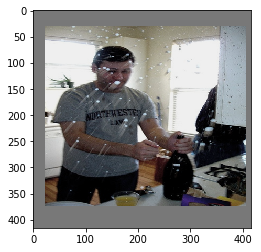

In [69]:
plt.imshow(image[ch][0])
plt.show()

In [70]:
train_logits[ch][0].shape

(1, 13, 13, 3, 25)

In [71]:
train_logits[ch][1].shape

(1, 26, 26, 3, 25)

In [72]:
train_logits[ch][2].shape

(1, 52, 52, 3, 25)

In [73]:
np.set_printoptions(threshold=np.inf)

### Real Dataset

Large Object (1,13,13,3,25) , Medium Object (1,26,26,3,25),Small Object (1,52,52,3,25)

In [233]:
lrg = train_logits[ch][0]
med = train_logits[ch][1]
sml = train_logits[ch][2]

Change the Variable to see other scale

In [234]:
arrp = lrg

In [235]:
arrp[:,:,:,:,:] #xy wh p classes/20/ (1, 13, 13, 3, 25)

array([[[[[0.        , 0.        , 0.        , 0.        , 0.        ,
           0.        , 0.        , 0.        , 0.        , 0.        ,
           0.        , 0.        , 0.        , 0.        , 0.        ,
           0.        , 0.        , 0.        , 0.        , 0.        ,
           0.        , 0.        , 0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        , 0.        , 0.        ,
           0.        , 0.        , 0.        , 0.        , 0.        ,
           0.        , 0.        , 0.        , 0.        , 0.        ,
           0.        , 0.        , 0.        , 0.        , 0.        ,
           0.        , 0.        , 0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        , 0.        , 0.        ,
           0.        , 0.        , 0.        , 0.        , 0.        ,
           0.        , 0.        , 0.        , 0.        , 0.        ,
           0.        , 0.        , 0.        , 0.        , 0.        ,
    

In [236]:
box = np.where(arrp[:,:,:,:,:] > 0 )
box

(array([0, 0, 0, 0, 0, 0], dtype=int64),
 array([6, 6, 6, 6, 6, 6], dtype=int64),
 array([5, 5, 5, 5, 5, 5], dtype=int64),
 array([2, 2, 2, 2, 2, 2], dtype=int64),
 array([ 0,  1,  2,  3,  4, 19], dtype=int64))

x,y,w,h,p and class

In [237]:
for i in range(1,( len(box[0])//5 +1) ):
    s = np.array(box)
    #print( i*5 )
    stp = i*5
    
    print( arrp[s[0,stp],s[1,stp],s[2,stp],s[3,stp],0:5] )
    print( arrp[s[0,stp],s[1,stp],s[2,stp],s[3,stp],5:25] )
    obnum =  np.argmax( arrp[s[0,stp],s[1,stp],s[2,stp],s[3,stp],5:25]) 
    print( "{} = {}".format(obnum, obj[ obnum ] ) )
    print("-------------------------------------------------------")

[0.41105768 0.52403843 0.6394231  0.72596157 1.        ]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
14 = person
-------------------------------------------------------


### Model Predict

Large Object (1,13,13,3,25) , Medium Object (1,26,26,3,25),Small Object (1,52,52,3,25)

In [224]:
lrg = model_logits[ch][0]
med = model_logits[ch][1]
sml = model_logits[ch][2]

Change the Variable to see other scale

In [225]:
arrp = lrg

In [226]:
arrp[:,:,:,:,:] #xy wh p classes/20/ (1, 13, 13, 3, 25)

array([[[[[ 2.83663660e-01, -6.91855311e-01, -6.84679449e-02,
           -3.91242839e-02, -1.17829809e+01, -1.10762987e+01,
           -5.39782095e+00, -8.21943569e+00, -8.33211327e+00,
           -6.98642731e+00, -6.74670744e+00, -9.81911469e+00,
           -6.66097975e+00, -4.43471336e+00, -6.38938379e+00,
           -9.18629265e+00, -9.46925640e+00, -8.33189011e+00,
           -7.20388794e+00, -5.26510048e+00, -3.64541459e+00,
           -5.47713614e+00, -1.00116262e+01, -9.01812458e+00,
           -6.29947090e+00],
          [ 8.43456164e-02,  5.31945407e-01, -2.79437244e-01,
            4.74928796e-01, -1.13916512e+01, -8.68808651e+00,
           -4.58899164e+00, -6.74916840e+00, -9.62366104e+00,
           -4.24286366e+00, -9.00627613e+00, -1.07501059e+01,
           -7.44500542e+00, -4.93926334e+00, -8.19220638e+00,
           -9.90747452e+00, -7.62368011e+00, -1.00421352e+01,
           -8.57808590e+00, -4.25265408e+00, -5.22711802e+00,
           -8.78691387e+00, -9.18974113e+

In [227]:
box = np.where(arrp[:,:,:,:,:] > 0 )
box

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

x,y,w,h,p and class

In [228]:
for i in range(1,( len(box[0])//5 +1) ):
    s = np.array(box)
    #print( i*5 )
    stp = i*5
    print( arrp[s[0,stp],s[1,stp],s[2,stp],s[3,stp],0:5] )
    print( arrp[s[0,stp],s[1,stp],s[2,stp],s[3,stp],5:25] )
    obnum =  np.argmax( arrp[s[0,stp],s[1,stp],s[2,stp],s[3,stp],5:25]) 
    print( "{} = {}".format(obnum, obj[ obnum ] ) )

[  1.1095325   -0.19371103  -0.05685298   0.13429873 -13.187858  ]
[-8.4632635 -4.9797797 -5.6373777 -6.6415668 -6.1282115 -6.3455405
 -5.2239447 -6.0043216 -6.044728  -7.14723   -8.324902  -3.7734268
 -7.0846457 -4.992002  -1.7501566 -3.1622996 -9.197111  -6.1567416
 -8.12489   -9.1437235]
14 = person
[  0.2132819   -0.19187267  -0.2135582    0.4832719  -12.637981  ]
[ -8.469903   -4.68552    -7.87922    -8.917014   -5.1154437  -9.293552
 -10.358058   -6.7701354  -4.045502   -7.3137736  -6.995173   -6.5135207
  -8.895038   -7.4215918  -1.822675   -3.0729017  -9.613263   -9.220246
  -9.542767   -9.333459 ]
14 = person
[-2.3766360e-03  7.6000500e-01  3.6070085e-01 -4.6643165e-01
 -1.6052883e+01]
[-9.5127125 -4.1912756 -3.914613  -4.6997485 -6.1397386 -7.6199603
 -7.5309258 -4.2962947 -3.9296494 -4.457707  -6.8261514 -5.808797
 -6.9768887 -5.494109  -1.2127869 -1.9710461 -4.9798846 -6.9465685
 -8.438431  -5.2948003]
14 = person
[  0.3502309    1.0426064    0.49780324  -0.63867855 -16.662

  -4.800588   -8.180326 ]
15 = pottedplant
[  0.18983042   0.5496945    0.30136108  -0.29067865 -19.961107  ]
[-10.419927   -6.6779547  -6.6468697  -2.5098903  -3.9038892 -13.10722
 -10.791256   -3.4004118  -5.641425   -6.763874   -7.2664347  -4.9638104
  -8.627929   -7.189847   -6.467206    1.1114992  -4.0995     -9.159128
  -8.024372   -7.069801 ]
15 = pottedplant
[  0.41711023   0.2725132    0.03718735  -0.49949867 -17.629473  ]
[-10.376764   -9.160814   -5.9627075  -1.3581734  -3.7574253  -9.25823
  -6.0893784  -6.3025436  -5.135432   -4.468552   -9.45269    -5.320792
  -5.669801   -9.037592   -4.380478    0.8018049 -10.749694   -8.638299
  -5.758943   -8.070867 ]
15 = pottedplant
[-1.2659147e-02  2.9741785e-01  3.5025585e-01 -2.6107532e-01
 -1.9399496e+01]
[-11.404745   -8.117822   -7.5957384  -2.9943988  -4.2996683 -13.557404
 -10.692373   -3.1445754  -5.5938706  -7.1711817  -8.3143215  -4.1042023
  -9.504446   -7.9656644  -8.11201     0.6184954  -4.197632   -9.212533
  -8.895215

  -1.0947713   -2.2101922   -9.733169    -9.492891    -0.95042294]
19 = tvmonitor
[  0.2818192    0.3962539   -0.08176938   0.02401583 -17.453936  ]
[-9.733766  -5.943529  -6.5020165 -3.3756533 -5.73534   -9.321717
 -4.419529  -4.273804  -4.218344  -7.947243  -9.922013  -9.07976
 -6.327164  -5.443962  -3.8677733 -1.5533875 -2.0574734 -9.166382
 -7.5632668  1.1326865]
19 = tvmonitor
[-8.7254144e-02  7.7859149e-03 -3.1992059e-02 -2.3119362e-01
 -1.5903414e+01]
[-7.566932  -4.2026453 -5.990743  -3.6429927 -4.5549917 -6.762307
 -3.7207937 -4.1615143 -3.5401103 -6.2272635 -8.012528  -7.2202187
 -6.5531645 -5.1100245 -2.7400007 -1.8154842 -1.8564571 -7.2990694
 -5.8265324  1.6053501]
19 = tvmonitor
[ -0.63556665  -0.23433526  -0.24637505   0.34461966 -11.720653  ]
[ -8.506883   -2.781198   -6.407076   -8.002162   -4.6439776  -8.83126
 -10.051612   -4.9026546  -6.7524595  -7.7150483  -9.749841   -6.808662
  -7.9578886  -7.1854744  -6.289535    3.4475749  -7.107624   -9.990212
  -8.368014   -8

[ -0.03084499   0.5071681    0.01841984  -0.12971134 -13.549309  ]
[ -7.7070603   -5.527936    -8.747857    -8.397215    -5.2873144
  -9.297224    -6.8106184   -7.7652173   -4.4491997  -10.128927
  -7.3770185   -9.794783   -10.854462    -8.740547     2.0657268
   0.30182326  -5.1193705  -11.950392    -5.570305    -5.812894  ]
14 = person
[ -0.44255954  -0.35041127   0.4712335   -0.35308206 -14.754343  ]
[-7.6465807  -3.8843334  -3.686222   -5.4824595  -6.333942   -7.5303984
 -5.0953994  -6.474873   -3.688872   -7.8758335  -4.5171576  -8.828826
 -5.5032372  -4.4240413   0.29202956 -1.2803073  -5.860175   -8.016643
 -6.562261   -3.2095299 ]
14 = person
[  0.032016     0.7530218   -0.04005289  -0.35078755 -10.804512  ]
[-7.6098204 -6.9299994 -9.05721   -6.9152966 -4.7765827 -6.3260813
 -3.1484227 -8.281812  -3.4511364 -6.844162  -6.3926706 -9.874825
 -5.451026  -8.377765   2.7394996 -2.5169146 -9.734689  -8.91252
 -4.8290014 -6.789565 ]
14 = person
[ -0.7894226    0.21316803   0.3544294  

14 = person
[-1.373133    1.8605503  -0.08264421 -0.08202463 -1.7126322 ]
[-11.320711  -10.184294  -11.016116  -11.673223   -9.611689   -7.260356
  -7.409814  -11.3568     -7.9575486 -12.353039   -8.273936  -14.013984
  -9.595912  -12.0729885   6.954795   -8.927397  -11.624246  -10.04375
 -10.277028  -10.817178 ]
14 = person
[-0.39202967  0.54198986  0.06224024  0.08711089 -9.995843  ]
[ -9.159318   -8.047283  -10.674555   -8.973302   -5.8626885  -9.196194
  -7.85098    -8.989768   -7.0420356 -11.199619   -6.9321375  -9.675241
 -10.055474   -8.74821     5.1432157  -3.7073133 -10.130973  -12.227548
  -9.0169     -7.7678504]
14 = person
[-0.6899679   1.3768358  -0.1343292  -0.05969155 -9.3811655 ]
[ -9.341276   -8.015084   -9.225382   -9.4194     -7.1517277  -5.2074633
  -5.6500335  -8.830401   -5.3283253 -10.387896   -7.1960087 -11.441786
  -7.13299    -8.697916    5.1940794  -5.272376  -10.384254   -7.937741
  -8.478703   -7.4553976]
14 = person
[ 5.0070682e-03  7.9947221e-01 -3.459011

 -10.123597   -9.3085575]
14 = person
[ -0.3133244    0.5156194   -0.16651024   0.28540155 -10.956565  ]
[ -9.386329   -8.130374   -9.672783   -8.97506    -3.4742067 -10.12459
  -7.945798   -7.644351   -5.5534396  -9.878413   -6.180799   -7.4422126
  -8.94689    -7.5625052   3.8561032  -4.2575903  -7.5693665 -10.905381
  -8.762951   -6.9334154]
14 = person
[ -0.12091022  -0.01422887  -0.2630626    0.06977195 -13.130697  ]
[-10.037205    -5.424439    -5.5436163   -7.859047    -3.0670722
  -7.623506    -6.725719    -6.546178    -4.557821    -7.607764
  -5.067112    -6.708133    -7.032939    -5.622572    -0.33088738
  -1.6634208   -8.394228    -6.4773636   -7.8039274   -1.5211641 ]
14 = person
[  0.39835978   0.37218794  -0.39217755   0.0255416  -12.598384  ]
[-8.753401  -5.793938  -7.675365  -7.6954827 -3.0555742 -5.5867395
 -4.899412  -6.5437207 -4.5189896 -9.355555  -6.792878  -7.26329
 -6.5470786 -6.3091326  2.2317984 -3.1681848 -9.702869  -6.9939685
 -6.9554024 -6.30067  ]
14 = perso

  -8.331089   -4.8625455]
14 = person
[ -0.02064207   0.0959553   -0.3158259   -0.07071322 -14.283695  ]
[-6.6183114 -5.0674787 -6.7656245 -7.30614   -1.1810406 -5.3662405
 -7.165409  -6.441154  -3.2057724 -8.911388  -5.2160187 -5.5374146
 -7.289189  -5.5597086  1.0333905 -3.8010786 -9.035986  -4.4019766
 -6.1477003 -3.9926147]
14 = person
[  0.39085102   0.27500302  -0.33223918  -0.15854585 -14.739786  ]
[-5.888146   -4.5589666  -6.472566   -7.232977   -1.410861   -5.242306
 -6.5749683  -5.3902483  -2.8061533  -8.874282   -6.977882   -4.938468
 -7.5335217  -5.036465    0.63757604 -3.901684   -8.935428   -5.156275
 -5.785208   -3.30326   ]
14 = person
[  0.50588137   0.48505458   0.13255215  -0.2379638  -15.810053  ]
[-6.976329   -4.0118423  -5.399037   -6.357018   -3.0353687  -6.0144463
 -5.7796555  -4.7952766  -3.4209225  -6.8555627  -5.718351   -4.5501456
 -6.680657   -4.9379296  -0.95647216 -2.8106365  -4.9698772  -5.0799475
 -5.13557    -0.89457566]
19 = tvmonitor
[  0.9788639   -

  -3.0188653   -8.652806    -5.889078    -6.647086    -4.5929875 ]
4 = bottle
[  0.4742468   -0.16443369  -0.07972001  -0.7200925  -12.739831  ]
[-7.0305543  -5.4284744  -6.9316196  -8.548597   -1.831946   -8.164965
 -7.907903   -8.060646    0.11700381 -8.367665   -2.2179325  -5.4868655
 -9.835623   -6.0607576  -2.8217998  -4.160677   -8.423859   -6.4618206
 -6.965765   -6.209042  ]
8 = chair
[  0.08408809   0.03476015   0.4665938   -0.41950607 -11.571438  ]
[ -8.311266    -7.5261126  -10.290066    -8.460899    -0.02269822
  -7.962063    -9.653342    -8.185579    -1.804548    -8.586218
  -3.108942    -7.0649085   -9.198       -8.533915    -4.800005
  -4.158095    -4.965469    -6.9911175   -7.763284    -7.9667864 ]
4 = bottle
[  0.4245928    1.0323844    0.678344     0.12930828 -12.016251  ]
[-9.110261  -9.352617  -7.718758  -8.153487  -0.9113866 -8.041952
 -8.606513  -4.584525  -4.001757  -6.679386  -1.1290892 -7.017609
 -9.825332  -6.630308  -4.247131  -3.1709638 -9.676577  -5.4790387

 -6.7716246  -4.2931266 ]
4 = bottle
[  0.0789334   -0.5984189   -0.12184679   0.06221447 -13.8921585 ]
[-5.0662694  -1.5701516  -5.927859   -6.8750305  -0.8804585  -7.0402946
 -8.429917   -5.046823   -0.62601864 -7.18285    -4.7930574  -4.3772306
 -5.7138104  -5.2674637  -2.0407732  -2.505289   -4.9760346  -7.373365
 -5.6200614  -6.27018   ]
8 = chair
[ 6.4839125e-01 -3.1428812e-03 -1.6469556e-01 -2.0424839e-02
 -1.3195789e+01]
[-7.144758  -6.0520287 -6.2310357 -7.5456395 -2.0370834 -6.4452353
 -6.2028327 -3.6580665 -3.5517712 -6.2683744 -5.3379216 -3.5513139
 -7.2529907 -5.4388103 -1.330605  -3.4496706 -6.6467075 -7.244849
 -7.016256  -7.1579   ]
14 = person
[  0.88015735  -0.6507306   -0.14699243   0.2818195  -15.382079  ]
[-6.023098   -7.337948   -8.043864   -7.640552   -0.5094496  -7.276704
 -9.595734   -5.475659    0.16769588 -6.2610326  -2.893681   -4.6644573
 -7.2514343  -7.5398707  -3.4163623  -3.50689    -4.6245885  -8.587036
 -6.713709   -7.813562  ]
8 = chair
[  0.45883146 

 -1.0572069e+01]
[-5.129268  -6.4233236 -8.582624  -5.394225  -4.1948776 -7.337598
 -6.281923  -5.5422177 -3.0348783 -5.9620442  1.3686664 -6.434588
 -7.2228694 -5.6148953 -4.79295   -4.694035  -7.163918  -8.766925
 -5.9281745 -7.7398643]
10 = diningtable
[  0.13307628  -0.39956716  -0.14240511  -0.45203412 -13.738193  ]
[-5.929787   -6.6315536  -8.252802   -5.1659303  -3.387522   -6.8107085
 -6.1384645  -4.500832   -2.5623028  -5.604211    0.41079655 -6.3562794
 -7.0079722  -5.4029803  -3.8654149  -4.668095   -7.516807   -9.202867
 -5.7952757  -7.19429   ]
10 = diningtable
[  0.46662042  -0.06491821   0.11237583   0.21083508 -14.587227  ]
[-6.1812243  -6.8744154  -9.099976   -5.225703   -2.9871542  -8.018192
 -7.4900727  -5.991845   -0.56792563 -4.569254   -3.604523   -5.266038
 -6.8800116  -6.1425295  -5.268386   -4.1804714  -4.7366867  -7.9837117
 -6.655346   -6.7622166 ]
8 = chair
[  0.16587442   0.3109674    0.10987611   0.23713744 -15.417335  ]
[-6.027274   -5.9756904  -8.409922 